In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import string
import io
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/agustin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def return_sia_compound_values(text):
    return sia.polarity_scores(text)['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/agustin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
def remove_stopword(text):
    new_text = []
    for e in text:
        if e not in stopwords and e.isalpha():
            new_text.append(e)
    text = new_text
    return " ".join(new_text)

def stemm(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

def contains_punctuation(text):
    punctuation = set(string.punctuation)
    for character in text:
        if character in punctuation:
            return True
    return False

def amount_of_punctuation(text):
    punctuation = set(string.punctuation)
    amount = 0
    for character in text:
        if character in punctuation: amount += 1
    return amount

In [4]:
tweets = pd.read_csv("train.csv", usecols=['id','text', 'target'])
test = pd.read_csv("test.csv")

In [5]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7434 non-null   int64 
 1   text    7434 non-null   object
 2   target  7434 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 232.3+ KB


In [6]:
tweets_metrics = tweets[['id','text','target']]
tweets_metrics['text_without_stopwords'] = tweets_metrics['text'].str.split()
tweets_metrics['text_without_stopwords'] = tweets_metrics['text_without_stopwords'].apply(remove_stopword)

tweets_metrics['length'] = tweets_metrics['text'].apply(lambda x: len(x))
tweets_metrics['avg_word_length'] = tweets_metrics['text'].str.split().apply(lambda x: [len(y) for y in x]).transform(lambda x: np.mean(x))
tweets_metrics['amount_of_words'] = tweets_metrics['text'].str.split().transform(lambda x: len(x))
unique_words_by_tweet = tweets_metrics['text'].transform(lambda x: x.split()).transform(lambda x: pd.Series(x).unique()).transform(lambda x: len(x))
tweets_metrics['amount_of_unique_words'] = unique_words_by_tweet
tweets_metrics['sentiment'] = tweets_metrics['text'].apply(lambda x: return_sia_compound_values(x))
tweets_metrics['stopwords_count'] = tweets_metrics['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords]))
tweets_metrics['punctuation_count'] = tweets_metrics['text'].apply(lambda x: amount_of_punctuation(x))
mentions = tweets_metrics['text'].str.findall(r'@.\S*?(?=\s|[:]|$)').to_frame()
tweets_metrics['mentions_count'] = mentions['text'].apply(lambda x: len(x))
hashtags = tweets_metrics['text'].str.findall(r'#[^?\s].*?(?=\s|$)')
tweets_metrics['hashtags_count'] = hashtags.apply(lambda x: len(x))
tweets_metrics['longest_word_length_without_stopwords'] = tweets_metrics['text_without_stopwords'].apply(lambda x: ([len(word) for word in str(x).lower().split() if not word.startswith('http')])).apply(lambda x: max(x) if len(x) > 0 else 0)

tweets_metrics.head()

,id,text,target,text_without_stopwords,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason May ALLAH Forgive us,69,4.384615,13,13,0.2732,6,1,0,1,7
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Canada,38,4.571429,7,7,-0.3400,0,1,0,0,6
2,5,All residents asked to 'shelter in place' are ...,1,All residents asked notified No evacuation she...,133,5.090909,22,20,-0.2960,11,3,0,0,10
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders California,65,7.125000,8,8,0.0000,1,2,0,1,10
4,7,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby smoke pours school,88,4.500000,16,15,0.0000,7,2,0,2,6


### Split de features

In [82]:
data_cols = ['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','mentions_count','hashtags_count','longest_word_length_without_stopwords']
basic_data_cols = ['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','longest_word_length_without_stopwords']
x_train, x_test, y_train, y_test = \
train_test_split(tweets_metrics[data_cols], tweets_metrics['target'], test_size = 0.25, random_state = 123)

In [8]:
vectorizer = TfidfVectorizer()
tfidf_lgbm = vectorizer.fit_transform(tweets_metrics.loc[:, 'text'])
array = tfidf_lgbm.todense()

In [9]:
df = pd.DataFrame(array)
df['output'] = tweets['target']
basic_features = tweets_metrics[['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','mentions_count','hashtags_count','longest_word_length_without_stopwords']]
tfidf_features = df.merge(basic_features, left_index = True, right_index = True)
tfidf_features

,0,1,2,3,4,5,6,7,8,9,...,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69,4.384615,13,13,0.2732,6,1,0,1,7
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38,4.571429,7,7,-0.3400,0,1,0,0,6
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,133,5.090909,22,20,-0.2960,11,3,0,0,10
3,0.0,0.416232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65,7.125000,8,8,0.0000,1,2,0,1,10
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88,4.500000,16,15,0.0000,7,2,0,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7429,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,136,7.058824,17,17,-0.7579,2,15,0,1,10
7430,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105,6.571429,14,14,-0.7579,2,9,0,1,10
7431,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,134,5.428571,21,21,0.9164,5,9,0,0,8
7432,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,139,4.384615,26,21,0.4118,9,7,0,0,7


In [10]:
features = tfidf_features.columns.drop('output')
x = tfidf_features.loc[:, features].values
y = tfidf_features.loc[:, 'output'].values

from sklearn.model_selection import train_test_split
x_tfidf_train, x_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(x, y, test_size = 0.25, random_state = 123)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_tfidf_train = sc.fit_transform(x_tfidf_train)
x_tfidf_test = sc.transform(x_tfidf_test)

### Split de TF-IDF

In [49]:
x_text_train, x_text_test, y_text_train, y_text_test = \
train_test_split(tweets_metrics['text'], tweets_metrics['target'], test_size = 0.25, random_state = 123)

In [50]:
tfid_vectorizer = TfidfVectorizer()
train_vectors = tfid_vectorizer.fit_transform(x_text_train)
test_vectors = tfid_vectorizer.transform(x_text_test)
print(train_vectors.shape, test_vectors.shape)

(5575, 17703) (1859, 17703)


### Split count vectorizer

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
count_train = count_vectorizer.fit_transform(x_text_train)
count_test = count_vectorizer.transform(x_text_test)
print(count_train.shape, count_test.shape, y_text_train.shape,y_text_test.shape )

(5575, 53543) (1859, 53543) (5575,) (1859,)


### Para submits

In [52]:
test = pd.read_csv("test.csv")

### TF-IDF

In [53]:
train_vectors_full = tfid_vectorizer.fit_transform(tweets_metrics['text'])
test_vectors_full = tfid_vectorizer.transform(test['text'])
y_train_full = tweets_metrics['target']
print(train_vectors_full.shape, test_vectors_full.shape )

(7434, 21529) (3263, 21529)


### KNN : baseline
 *En principio usando un bootstrap del set de entrenamiento para medir accuracy. Se utilizo un 25% del set para entrenar y el 75% restante para la predicción. Se utilizó la representación TF-IDF para el entrenamiento ya que KNN funciona con valores numericos.*
 
Methods

* fit(self, X, y) Fit the model using X as training data and y as target values

* get_params(self[, deep]) Get parameters for this estimator.

* kneighbors(self[, X, n_neighbors, …]) Finds the K-neighbors of a point.

* kneighbors_graph(self[, X, n_neighbors, mode]) Computes the (weighted) graph of k-Neighbors for points in X

* predict(self, X) Predict the class labels for the provided data.

* predict_proba(self, X) Return probability estimates for the test data X.

* score(self, X, y[, sample_weight]) Return the mean accuracy on the given test data and labels.

* set_params(self, \*\*params) Set the parameters of this estimator.

### KNN con basic features

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
max = knn.score(x_test, y_test)
actual = max
optimo = 1

for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    actual = knn.score(x_test, y_test)
    if max < actual:
        optimo = i 
        max = actual

print(optimo, max) #0.6853146853146853 con 20 con basic features 22 con features

22 0.6853146853146853


In [96]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=43)
all_accuracies = cross_val_score(estimator=knn, X=x_train, y=y_train, cv=40)
print(all_accuracies.mean())

0.6550295477903392


### KNN con TF-IDF

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_vectors, y_text_train)
max = knn.score(test_vectors, y_text_test)
actual = max
optimo = 1

for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(train_vectors, y_text_train)
    actual = knn.score(test_vectors, y_text_test)
    if max < actual:
        optimo = i 
        max = actual

print(optimo, max) #0.7961269499731038 con 49

49 0.7961269499731038


In [80]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=17)
all_accuracies = cross_val_score(estimator=knn, X=train_vectors, y=y_text_train, cv=40)
print(all_accuracies.mean())

0.7852595066803699


### KNN con count vectorizer

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(count_train, y_text_train)
max = knn.score(count_test, y_text_test)
actual = max
optimo = 1

for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(count_train, y_text_train)
    actual = knn.score(count_test, y_text_test)
    if max < actual:
        optimo = i 
        max = actual

print(optimo, max) #0.6778749159381304 con 1 (basura)

1 0.6761699838622915


### Submit

In [57]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(train_vectors_full, y_train_full)
predicted = knn.predict(test_vectors_full)

In [59]:
test['target'] = predicted
submit_kaggle = test.loc[:, ['id', 'target']]
submit_kaggle.to_csv("knn_tfidf.csv", index=False)

### XGBoost

In [54]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#acc = 0.7305002689618074(objective ='binary:logistic', colsample_bytree = 0.6, learning_rate = 0.01, max_depth = 35,alpha = 0.5, n_estimators = 140) 
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.65, learning_rate = 0.005,
                max_depth = 30,alpha = 0.7, n_estimators = 310) 
xg_reg.fit(x_train,y_train) 
y_pred = xg_reg.predict(x_test)

for i in range (0, len(y_pred)):
    if y_pred[i] >= 0.5:       
        y_pred[i] = 1 
    else:  
        y_pred[i]=0
        
accuracy = accuracy_score(y_pred,y_test)
print(accuracy)

0.7240451855836472


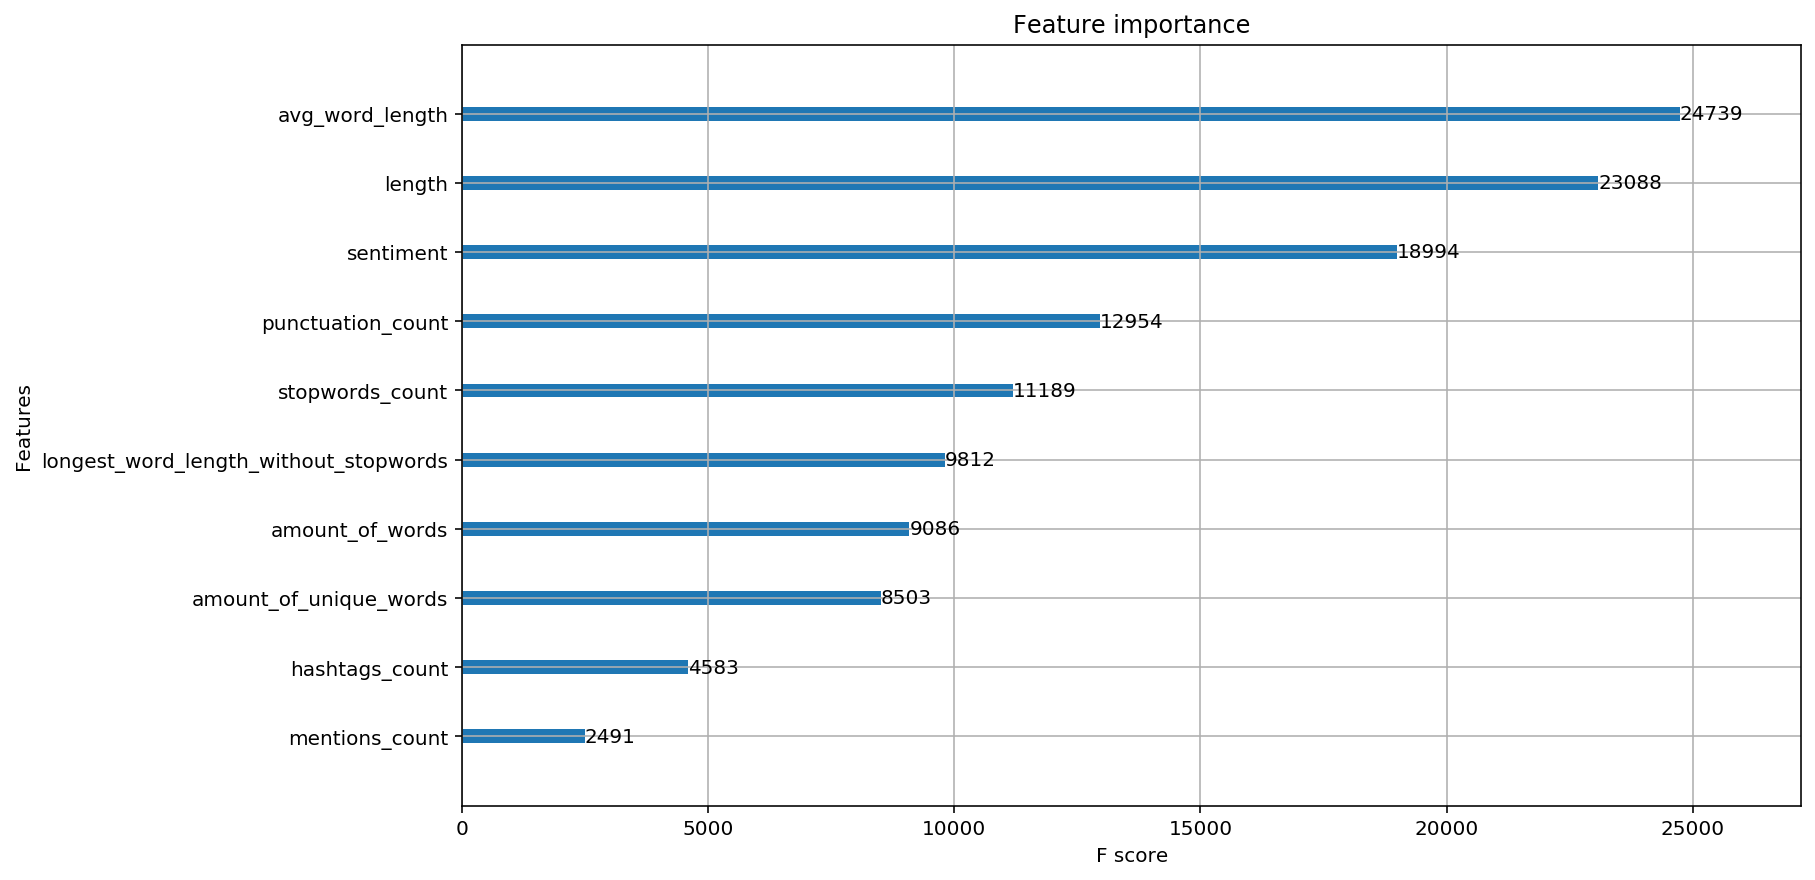

In [18]:
kfold = KFold(n_splits=10)
results = cross_val_score(xg_reg, x_train, y_train, cv=kfold)
results

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

### XGBoost con TF-IDF

In [247]:
#acu = 0.792361484669177objective ='reg:logistic', colsample_bytree = 0.45, colsample_bylevel = 0.4, learning_rate = 0.05, max_depth = 25, min_child_weight = 1.1, alpha = 0.5, gamma =  0.4, n_estimators = 210)
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', 
                          colsample_bytree = 0.45, colsample_bylevel = 0.4, learning_rate = 0.05,
                max_depth = 25, min_child_weight = 1.1, alpha = 0.5, gamma =  0.4, n_estimators = 210)
xg_reg.fit(train_vectors,y_text_train)
preds = xg_reg.predict(test_vectors)
for i in range (0, len(preds)):
    if preds[i] >= 0.5:       
        preds[i] = 1 
    else:  
        preds[i] = 0

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,y_text_test)
print(accuracy)

0.792361484669177


### Submit

In [267]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', 
                colsample_bytree = 0.45, colsample_bylevel = 0.4, learning_rate = 0.05,
                max_depth = 25, min_child_weight = 1.1, alpha = 0.5, gamma =  0.4, n_estimators = 210)
xg_reg.fit(train_vectors_full, y_train_full)
predicted = xg_reg.predict(test_vectors_full)
for i in range (0, len(predicted)):
    if predicted[i] >= 0.5:       
        predicted[i] = int(1.0)
    else:  
        predicted[i] = int(0)
test['target'] = predicted
test['target'] = test['target'].astype(int)
submit_kaggle = test.loc[:, ['id', 'target']]
submit_kaggle.to_csv("submit_prueba_20.csv", index=False)

In [249]:
from sklearn.model_selection import cross_val_score

xg_reg = xgb.XGBRegressor(objective ='reg:logistic', 
                colsample_bytree = 0.45, colsample_bylevel = 0.4, learning_rate = 0.05,
                max_depth = 25, min_child_weight = 1.1, alpha = 0.5, gamma =  0.4, n_estimators = 210)
all_accuracies = cross_val_score(estimator=xg_reg, X=train_vectors, y=y_text_train, cv=10)
print(all_accuracies.mean())

0.3486382501805172


In [25]:
from sklearn.model_selection import GridSearchCV

alpha_b = np.linspace(0.1, 0.9, 20)
alpha_b = np.around(alpha_b, decimals=4)
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
colsamples = [0.1, 0.2, 0.3, 0.35 ,0.4, 0.45,0.5, 0.55, 0.6,0.65, 0.7, 0.75, 0.8, 0.9]
estimators = [50, 100, 125, 150 ,175, 200,225, 250, 275,300, 325, 350, 375, 400]
dephs = [5, 10, 15, 20 ,25, 30,35, 40, 45,50, 55, 60, 65, 70]
parametros = [{'objective': ['binary:logistic'],'learning_rate':np.arange(0.01,0.5,0.02)},
                              {'n_estimators':np.arange(15,300,15)},
                              {'scale_pos_weight':np.arange(2,6,1)},
                              {'max_depth':np.arange(15,40,2),'min_child_weight':np.arange(1,10,1)},
                              {'gamma':np.arange(0,0.5,0.1), 'alpha' : np.arange(0.1,1,0.1)},
                              {'subsample':np.arange(0.6,1,0.1),'colsample_bytree':np.arange(0.5,0.91,0.05)},
                              {'colsample_bylevel':np.arange(0.6,0.91,0.05)}]
classifier = xgb.XGBRegressor()
gridsearch = GridSearchCV(classifier, parametros, scoring = 'roc_auc', cv = 4)
gridsearch.fit(train_vectors_full, y_train_full)
print("Best parameter: ",gridsearch.best_params_)

Best parameter:  {'learning_rate': 0.38999999999999996, 'objective': 'binary:logistic'}
